So far we've applied a number of different techniques to study the users and their linguistic features from r/MensRights and r/Feminism, but we haven't touched the question that we laid out in the beginning:

#####  Are r/MR and r/Fem polarlized at all?

In this part, we'll try to anwser this question at three levels:

1. Are the *words* polarized?
    * For example, what are the words dominating in r/MensRights but rarely seen in r/Feminism?

2. Are the *posts* polarized?
    * For example, suppose we have two collections of posts receiving highest scores in r/MR and in r/Fem, are there any linguistic features that can distinguish one from the other?

3. Are the *authors* polarized?
    * For example, consider the two collections of authors whose posts received in highest scores in r/MR and in r/Fem, respectively, can we separate them based on the linguistic features extracted from their posts?

Unlike the traditional bag-of-words language model, we'll make use of word and document embedding techniques (word2vec and doc2vec) to turn *words*, *posts*, and *authors* into real-valued vectors in high-dimensional space. The vector representation of words, posts, and authors are distributed in a way that semantically similar entities are also spatially close to each other.

The resulting vector representations will be visualized in 2D space using dimensionality technique tSNE, which preserves the distances of points in low dimensional space as much as in original high dimensional space, so entities that form clusters can be visible in 2D space.


In [1]:
import re
import datetime
import itertools
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pymongo import MongoClient

import pyLDAvis
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from scipy.spatial import distance

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))
sw.update(stopwords.words("english"))

Let's load the `doc2vec` model that we have trained.

In [2]:
import warnings
warnings.simplefilter('ignore')
    
from gensim import models
model = models.Doc2Vec.load("doc2vec_dbow_d100_n5_w15_mc5_s1e_05_t6.model")

Note that in `gensim`'s `doc2vec` model we can obtain *both* the document embedding and word embedding. For example,

1. The vector of document with tag `tag`: `model.docvecs[tag]`
2. The vector of word `word`: `model[word]`

We can do some quick checks to make sure the model was trained properly. We'll call the `most_similar()` function and check if the output list of words are semantically similar to the input word.

In [3]:
model.most_similar("race")

[(u'racial', 0.825962245464325),
 (u'ethnicity', 0.810067355632782),
 (u'races', 0.802207887172699),
 (u'ethnic', 0.7495372295379639),
 (u'color', 0.7449743151664734),
 (u'black', 0.7331588268280029),
 (u'racism', 0.7247092723846436),
 (u'white', 0.7186124920845032),
 (u'whites', 0.7181856036186218),
 (u'minorities', 0.7073538303375244)]

In [4]:
model.most_similar("money")

[(u'cash', 0.8195253610610962),
 (u'paying', 0.7856954336166382),
 (u'dollars', 0.7691073417663574),
 (u'fund', 0.7582569122314453),
 (u'funds', 0.7561745047569275),
 (u'paid', 0.7487441301345825),
 (u'pay', 0.7244888544082642),
 (u'spendable', 0.724132776260376),
 (u'pays', 0.7186272740364075),
 (u'profitable', 0.713617742061615)]

## 1. Subreddit-specific words

First, we would like to know what words show up more often in **r/MensRights** than in **r/Feminism**, and conversely those words show up more often in **r/Feminism** than in **r/MensRights**. In other words, what words are specific to (or overrepresented in) either subreddit.

As we did previously, we'll compute the log-odds ratio (zscore) that measures the extent to which a word is over-represented in one corpus with resepct to another corpus.

In [5]:
# Helper function for computing zscore (log-odds ratio)
def zscore(word,
           counter_i, n_i,
           counter_j, n_j,
           counter_0, n_0, log=np.log):
    """
    Input: `word`: the word that is present in both 'corpus_i' and 'corpus_j'

           `counter_i`: counter of words in 'corpus_i'
           `n_i`: total number of words in 'corpus_i'
           
           `counter_j`: counter of words in 'corpus_j'
           `n_j`: total number of words in 'corpus_j'
           
           `counter_0`: counter of words in the background corpus
           `n_0`: total number of words in the background corpus
           
    Function for computing the log-odds ratio. The LARGER the zscore, the MORE overrepresented
    the word `word` is in 'corpus_i' than in 'corpus_j'
    """
    
    y_i = np.float(counter_i[word])
    y_j = np.float(counter_j[word])
    a_w = np.float(counter_0[word])

    ratio_i = (y_i + a_w) / (n_i + n_0 - y_i - a_w)
    ratio_j = (y_j + a_w) / (n_j + n_0 - y_j - a_w)

    if ratio_i < 0.:
        raise ValueError("ratio_i is negative: %f\n" % ratio_i)
    if ratio_j < 0.:
        raise ValueError("ratio_j is negative: %f\n" % ratio_j)

    logratio = log(ratio_i) - log(ratio_j)

    try:
        var_logratio = 1. / (y_i + a_w) + 1. / (y_j + a_w)
    except ZeroDivisionError as inst:
        print inst

    try:
        z = logratio / np.sqrt(var_logratio)
    except Exception as inst:
        print inst

    return z

# Helper function that determines if a word is a valid word (i.e. \w+) and not belong to the stop-words
def valid_word(word):
    return re.match(r"[a-z]+$", word) is not None and word not in sw

# Helper function that retrieves the word vector from the trained doc2vec model
def word_vec(row):
    return pd.Series([model[row["word"]]])

Build the counter (`men_counter`, `fem_counter`, and `background_counter`) for the words that are present in the corpus used to train the `doc2vec` model (i.e. posts must have at least 30 tokens):

In [6]:
""" iterate over all posts that were used to train doc2vec model (that is,
`str(post["_id"]) in model.docvecs.doctags`), and update counter based on the
tokens in those posts
"""

men_counter = Counter()
fem_counter = Counter()

for post in db["MensRights"].find({}, {"tokens": 1, "_id": 1}):
    text = post["tokens"].split()
    if str(post["_id"]) in model.docvecs.doctags:   
        men_counter.update(text)

for post in db["Feminism"].find({}, {"tokens": 1, "_id": 1}):
    text = post["tokens"].split()
    if str(post["_id"]) in model.docvecs.doctags:
        fem_counter.update(text)       
        
background_counter = Counter()
background_counter.update(men_counter)
background_counter.update(fem_counter)  

Next
1. Compute the sizes of the corpora (`n_i`, `n_j`, and `n_0`)
2. Find the words that are present in both `men_counter` and `fem_counter`
3. Compute the zscores

In [7]:
n_i = sum(men_counter.values())
n_j = sum(fem_counter.values())
n_0 = sum(background_counter.values())

common = set(men_counter.keys()) & set(fem_counter.keys())
common = list(common)

df = [(w, zscore(w,
                 counter_i=men_counter, n_i=n_i,
                 counter_j=fem_counter, n_j=n_j,
                 counter_0=background_counter, n_0=n_0)) for w in common]

df = pd.DataFrame(df, columns=["word", "zscore"])
df = df.sort_values(by="zscore")

# Keep only the valid words
print df.shape
df = df[df["word"].map(valid_word)]
print df.shape

(81684, 2)
(63226, 2)


In [8]:
df[:3]

,word,zscore
77411,characters,-30.226672
14138,rfeminism,-22.565061
25508,character,-22.168835


In [9]:
df[-3:]

,word,zscore
54229,circumcision,17.841694
20800,child,22.296098
10037,men,22.930491


Now we have sorted the words in ascending order of zscores in `df`. Note that words with *low* zscores are overrepresented in **r/Feminism**, and those with *high* zscores are overrepresented in **r/MensRights**. We pick the 500 words with largest absolute values of zscores, and find their word vectors from the trained `doc2vec` model:

In [10]:
men_specific_word = df[["word"]][-500:]
fem_specific_word = df[["word"]][:500]

men_specific_word["vec"] = men_specific_word.apply(lambda row: word_vec(row), axis=1)
fem_specific_word["vec"] = fem_specific_word.apply(lambda row: word_vec(row), axis=1)

X_men_specific_word = np.array([v for v in men_specific_word["vec"]])
X_fem_specific_word = np.array([v for v in fem_specific_word["vec"]])

Note that when we trained the `doc2vec` model we specified the number of dimensionality to be 100 -- both document and words are represented by 100-dimensional real-valued dense vectors.

`X_men_specific_word` and `X_fem_specific_word` contains the vectors of words overly represented in **r/MensRights** and **r/Feminism**, respectively.

In [11]:
X_men_specific_word.shape, X_fem_specific_word.shape

((500, 100), (500, 100))

### WordCloud of overrepresented words

Next we'll visualize the top 50 overly represented words in either subreddit to have some idea about how different they are.

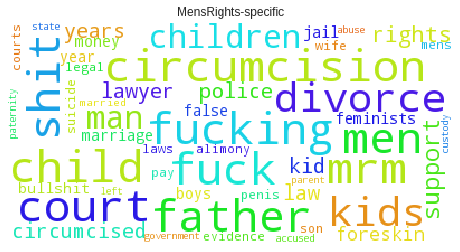

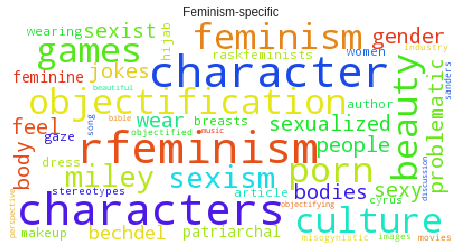

In [12]:
men = dict(df.iloc[-50:, :].values)
fem = dict(df.iloc[:50, :].values)

wc_men = WordCloud(max_font_size=40,
                   background_color='white').generate_from_frequencies((k, abs(men[k])) for k in men.keys())
wc_fem = WordCloud(max_font_size=40,
                   background_color='white').generate_from_frequencies((k, abs(fem[k])) for k in fem.keys())

plt.imshow(wc_men)
plt.title("MensRights-specific")
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(wc_fem)
plt.title("Feminism-specific")
plt.xticks([])
plt.yticks([])
plt.show()

As we can see, words that are overly represented in **r/MensRights** and **r/Feminism** seem to be semantically different:

1. r/MensRights-overrepresented words are related to *law and legal*, *sex*, *family and marriage*, and *curse words*
2. r/Feminism-overrepresented words are related to *objectification*, *dressing and body parts*, *online discussion on reddit*, *sex*, and *jargons in ideologies*

### Visualize the embedding of overrepresented words

Remember that `doc2vec` model provides not only the embedding of *documents* but also the embedding of *words*. So we can visualize the overly represented *words* in 2D vector space using the dimensionality reduction technique t-SNE. t-SNE is unique in that it preserve the distance between neighboring points in low dimensional space as much as possible. This would enable us to understand how these overly represented words are semantically related with each other.

`X_men_specific_word` and `X_fem_specific_word` hold the word embeddings

In [13]:
X_men_specific_word.shape, X_fem_specific_word.shape

((500, 100), (500, 100))

In [14]:
X = np.r_[X_men_specific_word, X_fem_specific_word]
tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [15]:
X.shape, X_tsne.shape

((1000, 100), (1000, 2))

In [16]:
X_men_specific_word_tsne = X_tsne[:500, :]
X_fem_specific_word_tsne = X_tsne[-500:, :]

Plot the embeddings in 2D space that are color-labeled:  <span style="color:red">**r/MensRights**</span> and <span style="color:blue">**r/Feminism**</span>

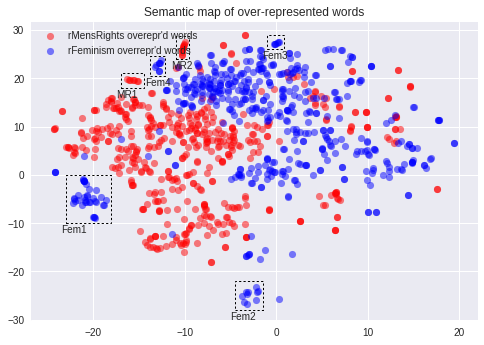

In [17]:
import matplotlib.patches as patches

plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="r", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[-500:, 0], X_tsne[-500:, 1], c="b", alpha=0.5, linewidths=0.1)
plt.legend(["rMensRights overepr'd words", "rFeminism overrepr'd words"], loc=2)

ax = plt.gca()

for coordinate, width, height, tag in [((-17, 18), 2.5, 3, "MR1"), ((-11, 24), 1.5, 4.8, "MR2")]:
    rect = patches.Rectangle(coordinate, width, height, linewidth=1, edgecolor='k',
                             facecolor='none', linestyle="dotted")
    ax.add_patch(rect)
    plt.text(coordinate[0] - 0.5, coordinate[1] - 2, tag, fontsize=10.0)

for coordinate, width, height, tag in [((-23, -10), 5, 10, "Fem1"), ((-4.5, -28), 3, 6, "Fem2"),
                                       ((-1, 26), 1.8, 3, "Fem3"), ((-13.8, 20.5), 1.7, 4, "Fem4")]:
    rect = patches.Rectangle(coordinate, width, height, linewidth=1, edgecolor='k',
                             facecolor='none', linestyle="dotted")
    ax.add_patch(rect)
    plt.text(coordinate[0] - 0.5, coordinate[1] - 2, tag, fontsize=10.0)
    
plt.title("Semantic map of over-represented words")    
plt.show()

Note that words overly represented in **r/MensRights** and in **r/Feminism** seem to occupy completely different spaces.

Also note that words embeddings form *clusters*. Here I manually picked some clusters and listed the words. As you can see, words that belong to the same cluster are *semantically* closely related and seem to form a cohesive *topic*.

In [18]:
for coordinate, width, height, tag in [((-17, 18), 2.5, 3, "MR1"),
                                       ((-11, 24), 1.5, 4.8, "MR2")]:
    index = np.where((X_men_specific_word_tsne[:, 0] < coordinate[0] + width) &
                     (X_men_specific_word_tsne[:, 0] > coordinate[0]) &
                     (X_men_specific_word_tsne[:, 1] < coordinate[1] + height) &
                     (X_men_specific_word_tsne[:, 1] > coordinate[1]))[0]
    
    print tag
    print ",".join(men_specific_word.iloc[index]["word"].values)
    print     
    
for coordinate, width, height, tag in [((-23, -10), 5, 10, "Fem1"),
                                       ((-4.5, -28), 3, 6, "Fem2"),
                                       ((-1, 26), 1.8, 3, "Fem3"),
                                       ((-13.8, 20.5), 1.7, 4, "Fem4")]:
    index = np.where((X_fem_specific_word_tsne[:, 0] < coordinate[0] + width) &
                     (X_fem_specific_word_tsne[:, 0] > coordinate[0]) &
                     (X_fem_specific_word_tsne[:, 1] < coordinate[1] + height) &
                     (X_fem_specific_word_tsne[:, 1] > coordinate[1]))[0]

    print tag
    print ",".join(fem_specific_word.iloc[index]["word"].values)
    print     

MR1
killing,deaths,died,killed,death,die,kill

MR2
students,colleges,universities,ix,student,campus,college,university,school,teachers,teacher

Fem1
wear,dress,makeup,wearing,hijab,clothing,hair,shaving,shave,bikini,clothes,costume,fashion,leggings,bra,heels,costumes,outfits,dressing,revealing,yoga,shaved,skirts,outfit,burqa,niqab,apparel,dressed,dresses,skirt,wore,hairy,armpit,hijabs,armpits

Fem2
ads,marketing,product,marketed,advertising,dove,magazines,runways,advertisements,ad

Fem3
jokes,tosh,joke,humor,comedians,comedy

Fem4
wnba,player,sports,athletes,sport,players,cheerleaders,volleyball



## 2. From polarized *words* to polarized *posts*

As we can see, we have found evidence that the overly represented *words* in **r/MensRights** and **r/Feminism** appear to be semantically different (or *polarized*). Next we'll follow up in the same direction by examining the *posts*: we'll focus on posts that received the highest scores (i.e. `upvotes` minus `downvotes`) in **r/MensRights** and **r/Feminism**, because the higher the score, the more people the post is endorsed by. We'll check if the posts are semantically *polarized* by plotting the document embeddings of posts in 2D space using t-SNE.

Note that the word vectors and document vectors produced by `doc2vec` are in the same *semantic space*. So technically we can compare the semantic distance between a *doc* vector and a *word* vector. 

First, we'll check if the top scoring posts in **r/MensRights** are semantically more similar to words over-represented in **r/MensRights** than in **r/Feminism**; and similarly, if the top scoring posts in **r/Feminism** are semantically more similar to words over-represented in **r/Feminism** than in **r/MensRights**.

To make the *doc-to-word* semantic comparison easier, we'll simply reduce the set of 500 (with largest absolute values of zscores) over-represented words in **r/MensRights** and **r/Feminism** (i.e. rows in `X_men_specific_word` and `X_fem_specific_word`) to their arithmetic mean (i.e. `X_men_specific_word_mean` and `X_fem_specific_word_mean`). Let's just call them the ***semantic poles*** of **r/MensRights** and **r/Feminism**:

In [19]:
# semantic poles (500-dimensional vector)
X_men_specific_word_mean = X_men_specific_word.mean(axis=0)
X_fem_specific_word_mean = X_fem_specific_word.mean(axis=0)

First, we'll retrieve the 500 top scoring posts in **r/MensRights** and **r/Feminism**. Then we'll find their document vectors from the `doc2vec` model we just trained, and visualize them (i.e. `X_men_top500_post` and `X_fem_top500_post`) together with the semantic poles (i.e. `X_men_specific_word_mean` and `X_fem_specific_word_mean`)  using t-SNE.

In [20]:
def get_posts(limit=None):
    """
    Get the document embeddings
    """
    X_men_post = []
    X_fem_post = []
    
    score_men_post = []
    score_fem_post = []

    # Sort all posts in descending order of the `score` (i.e. `upvotes` minus `downvotes`),
    for post in db["MensRights"].find({}, {"score": 1, "_id": 1}).sort("score", pymongo.DESCENDING):
            
        if str(post["_id"]) in model.docvecs.doctags:   
            X_men_post.append(model.docvecs[str(post["_id"])])
            score_men_post.append(post["score"])
        if limit is not None and len(X_men_post) >= limit:
            break
        
    for post in db["Feminism"].find({}, {"score": 1, "_id": 1}).sort("score", pymongo.DESCENDING):
    
        if str(post["_id"]) in model.docvecs.doctags:
            X_fem_post.append(model.docvecs[str(post["_id"])])
            score_fem_post.append(post["score"])
        if limit is not None and len(X_fem_post) >= limit:
            break
        
    X_men_post = np.array(X_men_post)
    X_fem_post = np.array(X_fem_post)
    score_men_post = np.array(score_men_post)
    score_fem_post = np.array(score_fem_post)
    return X_men_post, X_fem_post, score_men_post, score_fem_post

In [21]:
X_men_top500_post, X_fem_top500_post, _, _ = get_posts(limit=500)

In [22]:
# docment and word embeddings to be visualized
(X_men_top500_post.shape,
 X_fem_top500_post.shape,
 X_men_specific_word_mean.shape,
 X_fem_specific_word_mean.shape)

((500, 100), (500, 100), (100,), (100,))

Fit t-SNE model on the document vectors and semantic poles:

In [23]:
X = np.r_[X_men_top500_post,
          X_men_specific_word_mean[np.newaxis, :],
          X_fem_specific_word_mean[np.newaxis, :],
          X_fem_top500_post,]

tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [24]:
X.shape, X_tsne.shape

((1002, 100), (1002, 2))

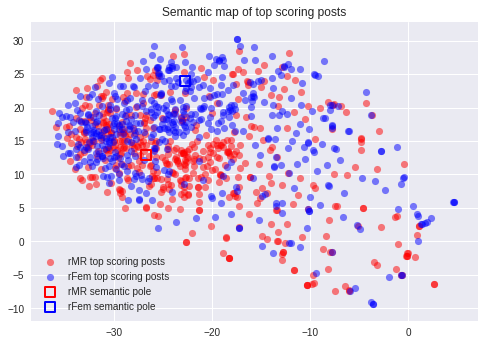

In [25]:
plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="r", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[-500:, 0], X_tsne[-500:, 1], c="b", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[500, 0], X_tsne[500, 1], linewidths=2, edgecolors="r", marker="s", facecolor="", s=100)
plt.scatter(X_tsne[501, 0], X_tsne[501, 1], linewidths=2, edgecolors="b", marker="s", facecolor="", s=100)
plt.legend(["rMR top scoring posts",
            "rFem top scoring posts",
            "rMR semantic pole",
            "rFem semantic pole"], loc=3)

plt.title("Semantic map of top scoring posts")
plt.show()

As we can see, the document embeddings of top scoring posts in **r/MensRights** and **r/Feminism** *still* occupy different space in this *semantic map* (though the contrast was not as conspicuous as the case for polarized words): r/MensRights semantic pole (<span style="color:red">red square</span>) are surrounded by more top scoring posts in **r/MensRights** (<span style="color:red">red dots
</span>); similarly, r/Feminism semantic pole (<span style="color:blue">blue square</span>) are surrounded by more top scoring posts in **r/Feminism** (<span style="color:blue">blue dots</span>).

### Semantic distance between document vector and word vector

Next we'll *quantitatively* measure the semantic distance of each vector in `X_men_top500_post` and `X_fem_top500_post` (i.e. <span style="color:red">red dots</span> and <span style="color:blue">blue dots</span>, respectively) against semantic poles (i.e. <span style="color:red">red</span> and <span style="color:blue">blue</span> squares).

For the distance measure, we'll consider cosine and euclidean distance.

In [26]:
# Helper function that computes the average distance (cosine and euclidean) 
# between a list of vectors `vectors` and a set of target vectors from `centers`
def cos_and_eucl_dist(vectors, centers):
    cosine_dist = np.array([np.mean([distance.cosine(vec, center) for center in centers]) for vec in vectors])
    euclidean_dist = np.array([np.mean([np.linalg.norm(vec - center) for center in centers]) for vec in vectors])
    
    return cosine_dist, euclidean_dist  

In [27]:
# Plot the kernel density distribution curves of distance measures 
def plot_dist(cosine_dists, euclidean_dists, ymax, labels, titles, colors=["r", "b"], linestyle=["-", "-"]):
    
    lines = len(cosine_dists)
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    for i in range(lines):
        sns.kdeplot(cosine_dists[i], ax=ax1, c=colors[i], label=labels[i], linestyle=linestyle[i])
    for i in range(lines):
        ax1.vlines(cosine_dists[i].mean(), 0, ymax[0], color=colors[i], linewidth=0.5, linestyle=linestyle[i])
        
    for i in range(lines):
        sns.kdeplot(euclidean_dists[i], ax=ax2, c=colors[i], label=labels[i], linestyle=linestyle[i])
    for i in range(lines):
        ax2.vlines(euclidean_dists[i].mean(), 0, ymax[1], color=colors[i], linewidth=0.5, linestyle=linestyle[i])
        
    ax1.set_xlabel("cosine distance")
    ax2.set_xlabel("Euclidean distance")
    ax1.set_ylabel("Density")
    ax2.set_ylabel("Density")
    ax1.set_title(titles[0])
    ax2.set_title(titles[1])
    
    ax1.legend(loc=9)
    ax2.legend(loc=9)
    f.set_figheight(3)
    f.set_figwidth(12)

In [28]:
cosine_men500__menspecific, euclidean_men500__menspecific = cos_and_eucl_dist(X_men_top500_post, [X_men_specific_word_mean])
cosine_men500__femspecific, euclidean_men500__femspecific = cos_and_eucl_dist(X_men_top500_post, [X_fem_specific_word_mean])

In [29]:
%matplotlib inline

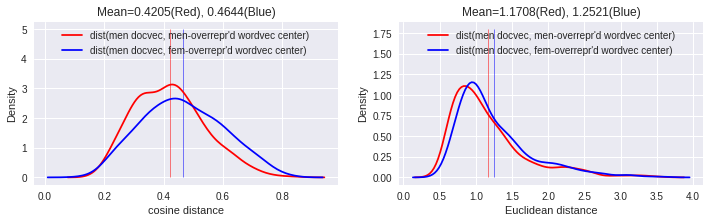

In [30]:
plot_dist([cosine_men500__menspecific, cosine_men500__femspecific],
          [euclidean_men500__menspecific, euclidean_men500__femspecific], [5, 1.8],
          labels=["dist(men docvec, men-overrepr'd wordvec center)",
                      "dist(men docvec, fem-overrepr'd wordvec center)"],
          titles=["Mean=%.4f(Red), %.4f(Blue)" % (cosine_men500__menspecific.mean(), cosine_men500__femspecific.mean()),
                  "Mean=%.4f(Red), %.4f(Blue)" % (euclidean_men500__menspecific.mean(), euclidean_men500__femspecific.mean())])

In [31]:
cosine_fem500__menspecific, euclidean_fem500__menspecific = cos_and_eucl_dist(X_fem_top500_post, [X_men_specific_word_mean])
cosine_fem500__femspecific, euclidean_fem500__femspecific = cos_and_eucl_dist(X_fem_top500_post, [X_fem_specific_word_mean])

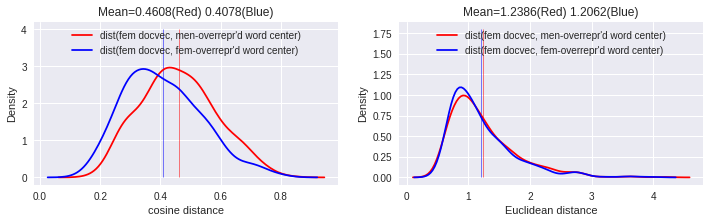

In [32]:
plot_dist([cosine_fem500__menspecific, cosine_fem500__femspecific],
          [euclidean_fem500__menspecific, euclidean_fem500__femspecific], [4.0, 1.8],
          labels=["dist(fem docvec, men-overrepr'd word center)",
                  "dist(fem docvec, fem-overrepr'd word center)"],
          titles=["Mean=%.4f(Red) %.4f(Blue)" % (cosine_fem500__menspecific.mean(), cosine_fem500__femspecific.mean()),
                  "Mean=%.4f(Red) %.4f(Blue)" % (euclidean_fem500__menspecific.mean(), euclidean_fem500__femspecific.mean())])

In [33]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


As we can see, <span style="color:red">red dots</span> are generally closer to <span style="color:red">red square</span>, and similarly, <span style="color:blue">blue dots</span> are generally closer to <span style="color:blue">blue square</span>. This means that the polarized words and documents are generally semantically *aligned* if they are from *same* subreddit.

### Correlation between score and semantics

Note that in the analysis above, we just found that top scoring posts are generally semantically closer to the words that are overrepresented in the same subreddit (e.g. <span style="color:red">red dots</span> are generally closer to <span style="color:red">red square</span>). This would naturally lead us to the following question:

What causes a particular post to receive high scores in either **r/MensRights** or **r/Feminism**? Can this be accounted for by its semantic content? For example, if your post contains more overrepresented words in **r/Feminism**, would this increase your chance of receiving high scores in **r/Feminism**?  

To answer this question, let's consider all the posts for which there is an document vector (i.e. not limited to 500 top-scoring posts), and check if there is any quantitative relationship between the post score and the semantic distance with respect to the two semantic poles.

In [34]:
X_men_post, X_fem_post, score_men_post, score_fem_post = get_posts()

cosine_men__menspecific, _ = cos_and_eucl_dist(X_men_post, [X_men_specific_word_mean])
cosine_men__femspecific, _ = cos_and_eucl_dist(X_men_post, [X_fem_specific_word_mean])
cosine_fem__menspecific, _ = cos_and_eucl_dist(X_fem_post, [X_men_specific_word_mean])
cosine_fem__femspecific, _ = cos_and_eucl_dist(X_fem_post, [X_fem_specific_word_mean])

In [35]:
%matplotlib inline

I could have just shown a score-distance scatter plot, but scatter plot may not be very informative if the correlation between the two variables is not strong enough. Instead, we split the data into 10 subsets that contain approximately equal number of points, with distance in ascending order across 10 subsets. We illustrate the score average of points in each subsets as a function of the distance range in each subset:

In [36]:
def plot_dist_score(dist_score, titles):
    f, axes = plt.subplots(1, 2, sharey=True)
    for i, ((dist, score), title) in enumerate(zip(dist_score, titles)):
        df = pd.DataFrame([dist, score]).T
        df.columns = ["distance", "score"]
        factor = pd.qcut(df["distance"], 10) # cut into 10 equal sized bins
        ax = axes[i]
        df["score"].groupby(factor).mean().plot(ax=ax) # mean score of each bin
        xlabels = ax.get_xticklabels()
        ax.set_xticklabels(xlabels, rotation=45)
        ax.set_title(title)
        ax.set_ylabel("score")
    f.set_figheight(3)
    f.set_figwidth(10)

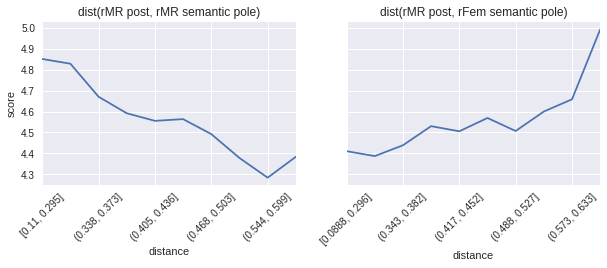

In [37]:
plot_dist_score([[cosine_men__menspecific, score_men_post], [cosine_men__femspecific, score_men_post]],
                ["dist(rMR post, rMR semantic pole)", "dist(rMR post, rFem semantic pole)"])

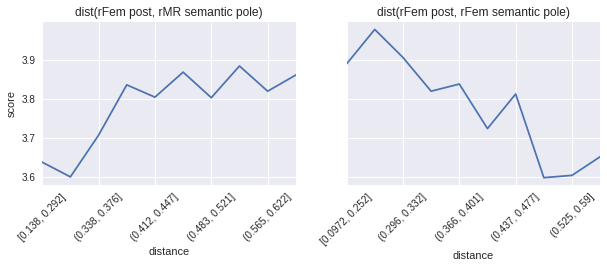

In [38]:
plot_dist_score([[cosine_fem__menspecific, score_fem_post], [cosine_fem__femspecific, score_fem_post]],
                ["dist(rFem post, rMR semantic pole)", "dist(rFem post, rFem semantic pole)"])

As you can see, when the posts in **r/MensRights** move away from the **r/MensRights** semantic pole (i.e. `X_men_specific_word_mean`) and move towards **Feminism** semantic pole (i.e `X_fem_specific_word_mean`), the score is going down; and we can see a similar trend for **r/Feminism** posts and scores.

The means that the semantic poles derived from the over-represented *words* also apply to the *posts*. And in practice the sore of a post can be predicted based on its semantic distance to the semantic poles.

In [39]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


## 3.1 Semantic Characterization of Authors: Author-vector

Now that we have some intuitive understanding about how polarized the distribution of the *words* and *posts* are, let's move on to *authors*. We'll profile authors by building *author vector* that semantically summarizes the posts of the same author. Because of the antagonistic nature of the relationship between **r/MensRights** and **r/Feminism**, we'll focus on *polarized* authors.

For each subreddit, we'll focus on two groups of authors

1. *Cross-posters*:
    1. **Who**: those who posted in both **r/MensRights** and **r/Feminism**
    2. **How to selecte polarized authors**: the posts made in one subreddit (aka *home subreddit*) received much higher scores than in the other subreddit (aka *away subreddit*): that is, the ***minimum*** score in the *home subreddit* must be greater than the ***maximum*** of the *away* subreddit
2. *Non-crossposters*:
    1. **Who**: those who posted in exclusively in one subreddit.
    2. **How to selecte polarized authors**: select only the authors whose posts received the highest scores.

Note that for *cross-posters* (who posted in both subreddits), we separately consider their posts in *home subreddit* and *away subreddit*:

<img src="https://github.com/chao-ji/reddit/blob/master/authvec.png?raw=true" width="600">

Before we proceed with our main goal, that is, the semantic characterization of authors, let's first do a sanity check of if users have a biased choice of posting in r/MR or r/Fem.

Specifically, for each crossposter (who posted in both rMR and rFem) we'll calculate the ratio of the number of rMR posts over the total posts.

In [40]:
df = pd.concat([pd.DataFrame(list(db["MensRights"].find({}, {"score": 1, "subreddit": 1,
                                                             "author": 1, "_id": 0}))),
                pd.DataFrame(list(db["Feminism"].find({}, {"score": 1, "subreddit": 1,
                                                           "author": 1, "_id": 0})))],
               axis=0)

In [41]:
def polarity(df, cutoff=0):
    s = df["subreddit"].value_counts()
    
    if len(s) == 2 and s.sum() >= cutoff:
        return float(s["MensRights"]) / s.sum()
    else:
        return np.nan

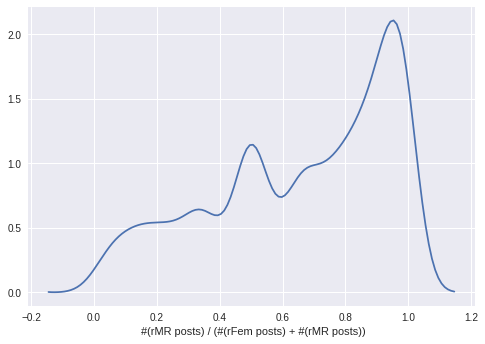

In [42]:
a = df.groupby("author").apply(lambda x: polarity(x))
a = a[a.notnull()]
sns.kdeplot(a)
plt.xlabel(" #(rMR posts) / (#(rFem posts) + #(rMR posts))")
plt.show()

If most crossposters' are neutral (i.e. they don't have preference in either rMR or rFem), then they would post approximately equal number of posts in rMR and rFem, and the histogram would look like a bell-shaped distirbution centered around 0.5.

Here we do see a peak around 0.5, which corresponds to the neutral crossposters, but it seems that most users seem to "prefer" rMR (the big peak at far right).


Now let's change the criteria by considering only crossposters with at least 10 posts:

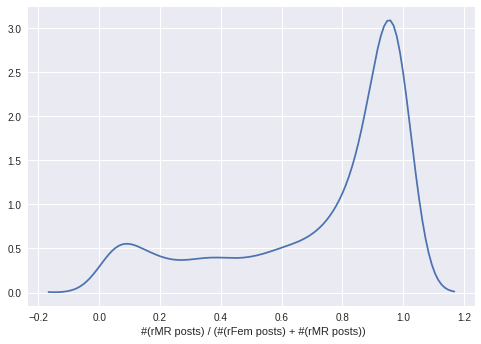

In [43]:
a = df.groupby("author").apply(lambda x: polarity(x, 10))
a = a[a.notnull()]
sns.kdeplot(a)
plt.xlabel(" #(rMR posts) / (#(rFem posts) + #(rMR posts))")
plt.show()

This time, we do see a small peak at far left and a big peak at far right. The far-right big peak might be due to fact that there are overwhemingly more posts in rMR than in rFem. So we can say the cross-posters a biased preference in rMR or rFem, at least for those with at least ten posts.

With sanity check verified, let's proceed with the analysis.

First we need a few helper functions that compute basic statistics for each author:

In [44]:
# Helper function that returns the mean, min, max, and count of the scores of posts belonging to the same author

del X_men_post, X_fem_post, score_men_post, score_fem_post
del cosine_men__menspecific, cosine_men__femspecific, cosine_fem__menspecific, cosine_fem__femspecific

def agg_author(df):
    men_mean_score = df[df["subreddit"] == "MensRights"]["score"].mean()
    men_min_score = df[df["subreddit"] == "MensRights"]["score"].min()
    men_max_score = df[df["subreddit"] == "MensRights"]["score"].max()
    men_count = df[df["subreddit"] == "MensRights"]["score"].shape[0]
    
    fem_mean_score = df[df["subreddit"] == "Feminism"]["score"].mean()
    fem_min_score = df[df["subreddit"] == "Feminism"]["score"].min()
    fem_max_score = df[df["subreddit"] == "Feminism"]["score"].max()
    fem_count = df[df["subreddit"] == "Feminism"]["score"].shape[0]
    
    return pd.Series([men_mean_score, men_min_score, men_max_score, men_count,
                      fem_mean_score, fem_min_score, fem_max_score, fem_count],
                     index=["men_mean_score", "men_min_score", "men_max_score", "men_count",
                            "fem_mean_score", "fem_min_score", "fem_max_score", "fem_count"])

In [45]:
# Helper function that returns the authors in two groups from two subreddits
# `men_cp_polar`: polarized cross-posters in rMR
# `fem_cp_polar`: polarized cross-posters in rFem
# `men_only_polar`: polarized non-crossposters in rMR
# `fem_only_polar`: polarized non-crossposters in rFem

def polarized_authors(authors):
    men_author = pd.DataFrame(authors[authors["men_mean_score"].notnull()][["men_mean_score", "men_min_score",
                                                                            "men_max_score", "men_count"]])
    men_author = men_author.reset_index()
    
    fem_author = pd.DataFrame(authors[authors["fem_mean_score"].notnull()][["fem_mean_score", "fem_min_score",
                                                                            "fem_max_score", "fem_count"]])
    fem_author = fem_author.reset_index()
    
    print men_author.shape, fem_author.shape
    
    # `men_author`: users who posted >= 1 post in `r/MensRights`
    # `fem_author`: users who posted >= 1 post in `r/Feminism`
    # `df`: cross-posters
    df = men_author.merge(fem_author, left_on="author", right_on="author")
    
    # 1. Find polarized crossposters 
    # minimum of MR score > maxinum of Fem score
    men_cp_polar = pd.DataFrame(df[df["men_min_score"] > df["fem_max_score"]])
    men_cp_polar = men_cp_polar.sort_values("men_max_score", ascending=False)
    men_cp_polar = list(men_cp_polar["author"])
    
    # minimum of Fem score > maxinum of MR score
    fem_cp_polar = pd.DataFrame(df[df["fem_min_score"] > df["men_max_score"]])
    fem_cp_polar = fem_cp_polar.sort_values("fem_max_score", ascending=False)
    fem_cp_polar = list(fem_cp_polar["author"])
    
    # 2. Find polarized non-crossposters
    men_only_polar = set(men_author["author"]) - set(fem_author["author"])
    fem_only_polar = set(fem_author["author"]) - set(men_author["author"])
    
    men_only_polar = pd.DataFrame(men_author[men_author["author"].isin(men_only_polar)])
    fem_only_polar = pd.DataFrame(fem_author[fem_author["author"].isin(fem_only_polar)])

    men_only_polar = men_only_polar.sort_values("men_max_score", ascending=False)
    men_only_polar = list(men_only_polar["author"])

    fem_only_polar = fem_only_polar.sort_values("fem_max_score", ascending=False)
    fem_only_polar = list(fem_only_polar["author"])
        
    return men_cp_polar, fem_cp_polar, men_only_polar, fem_only_polar

In [46]:
men = pd.DataFrame(list(db["MensRights"].find({}, {"author": 1, "score": 1, "subreddit": 1,
                                                   "_id": 1})))
fem = pd.DataFrame(list(db["Feminism"].find({}, {"author": 1, "score": 1, "subreddit": 1,
                                                 "_id": 1})))
print men.shape, fem.shape

reddit_posts = pd.concat([men, fem], axis=0)
reddit_posts = reddit_posts[reddit_posts["_id"].map(lambda x: str(x) in model.docvecs.doctags)] # keep posts for which there is a document vector
reddit_posts = reddit_posts.drop("_id", axis=1)
print reddit_posts.shape
reddit_posts[:3]

(2452716, 4) (213100, 4)
(1467591, 3)


,author,score,subreddit
0,sibqm_lmvm,2,MensRights
1,Mitschu,1,MensRights
2,aetheralloy,5,MensRights


Create dataframe with author info (number of posts, mean, max, min of scores)

In [47]:
authors = reddit_posts.groupby("author").apply(agg_author)
authors[:3]

,men_mean_score,men_min_score,men_max_score,men_count,fem_mean_score,fem_min_score,fem_max_score,fem_count
author,,,,,,,,
---,6.785714,-2.0,27.0,14.0,NaN,NaN,NaN,0.0
----x----,29.000000,29.0,29.0,1.0,NaN,NaN,NaN,0.0
---___________---,-2.000000,-2.0,-2.0,1.0,NaN,NaN,NaN,0.0


Obtain the list of authors in different groups:

In [48]:
men_cp_polar, fem_cp_polar, men_only_polar, fem_only_polar = polarized_authors(authors)

(77375, 5) (22837, 5)


In [49]:
print men_cp_polar[:3], fem_cp_polar[:3], men_only_polar[:3], fem_only_polar[:3]

[u'AmerikanInfidel', u'Ded0099', u'PaddyRamoutar'] [u'anUnkindness', u'ArmedPigeon', u'ducky-box'] [u'suicidalgod', u'PuckyMacpuckpants', u'DavidByron2'] [u'Readvoter', u'its_all_too_much', u'psychologyst']


In [50]:
len(men_cp_polar), len(fem_cp_polar), len(men_only_polar), len(fem_only_polar)

(616, 684, 71461, 16923)

The authors in each group are keyed on the highest score over all the post scores they received, and they are ranked in descending order of the key. We'll keep only top 500 authors:

In [51]:
men_cp_polar = men_cp_polar[:500]
fem_cp_polar = fem_cp_polar[:500]
men_only_polar = men_only_polar[:500]
fem_only_polar = fem_only_polar[:500]

#index1 = np.random.choice(len(men_only_polar), 500, replace=False)
#index2 = np.random.choice(len(fem_only_polar), 500, replace=False)

#men_only_polar = [men_only_polar[i] for i in index1]
#fem_only_polar = [fem_only_polar[i] for i in index2]

In [52]:
len(men_cp_polar), len(fem_cp_polar), len(men_only_polar), len(fem_only_polar)

(500, 500, 500, 500)

Define helper function `get_doc_vec_of_author` that computes the average of the document embedding over the posts made by a given `author` in a given `subreddit`

In [53]:
def get_doc_vec_of_author(author, subreddits, ndim=100):
    """
        Given `author` and `subreddit`, retrieve the doc vectors for all the posts made by 
        `author` in `subreddit` and
        return 1. author id,
               2. average score,
               3. the average of the doc vectors
               4. th number of posts (i.e. support)
    """
    
    score = 0.
    vec = np.zeros(ndim)
    support = 0.
    
    for subreddit in subreddits:
        post_by_author = db[subreddit].find({"author": author}, {"score": 1, "_id": 1})
        for post in post_by_author:
            if str(post["_id"]) in model.docvecs:
                score += post["score"]
                vec += model.docvecs[str(post["_id"])]
                support += 1.
    
    score /= support
    vec /= support
    return author, score, vec, int(support)


Create profile information for each author: author ID, average score, author vector (average of document vectors of author'posts), support (count of author's posts)

In [54]:
men_cp_polar_home = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["MensRights"]), men_cp_polar),
                            columns=["author", "score", "vec", "support"])
fem_cp_polar_home = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["Feminism"]), fem_cp_polar),
                            columns=["author", "score", "vec", "support"])

men_cp_polar_away = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["Feminism"]), men_cp_polar),
                            columns=["author", "score", "vec", "support"])
fem_cp_polar_away = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["MensRights"]), fem_cp_polar),
                            columns=["author", "score", "vec", "support"])

men_only_polar = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["MensRights"]), men_only_polar),
                              columns=["author", "score", "vec", "support"])
fem_only_polar = pd.DataFrame(map(lambda x: get_doc_vec_of_author(x, ["Feminism"]), fem_only_polar),
                              columns=["author", "score", "vec", "support"])

In [55]:
men_cp_polar_home[:1]

,author,score,vec,support
0,AmerikanInfidel,293.5,"[0.00772101432085, -0.165015406907, -0.1427637...",2


In [56]:
fem_cp_polar_home[:1]

,author,score,vec,support
0,anUnkindness,63.714286,"[-0.0495606511556, -0.0548190759229, -0.085354...",7


In [57]:
men_cp_polar_away[:1]

,author,score,vec,support
0,AmerikanInfidel,-2.5,"[0.008376121521, -0.175384216011, -0.173881150...",2


In [58]:
fem_cp_polar_away[:1]

,author,score,vec,support
0,anUnkindness,1.0,"[0.0572927296162, -0.14572635293, -0.139566689...",1


In [59]:
men_only_polar[:1]

,author,score,vec,support
0,suicidalgod,307.625,"[0.00370599818416, -0.131140870508, -0.0573976...",8


In [60]:
fem_only_polar[:1]

,author,score,vec,support
0,Readvoter,42.625,"[-0.0836069840007, -0.129222503863, -0.2033582...",8


In [61]:
(men_cp_polar_home.shape, fem_cp_polar_home.shape,
 men_cp_polar_away.shape, fem_cp_polar_away.shape,
 men_only_polar.shape, fem_only_polar.shape)

((500, 4), (500, 4), (500, 4), (500, 4), (500, 4), (500, 4))

In [62]:
(men_cp_polar_home["support"].mean(), fem_cp_polar_home["support"].mean(),
 men_cp_polar_away["support"].mean(), fem_cp_polar_away["support"].mean(),
 men_only_polar["support"].mean(), fem_only_polar["support"].mean())

(4.658, 2.18, 2.124, 4.304, 243.048, 24.604)

Stack the author vectors in Numpy 2-D array, shape = (500, 100)

In [63]:
X_men_cp_polar_home = np.array([v for v in men_cp_polar_home["vec"]])
X_fem_cp_polar_home = np.array([v for v in fem_cp_polar_home["vec"]])

X_men_cp_polar_away = np.array([v for v in men_cp_polar_away["vec"]])
X_fem_cp_polar_away = np.array([v for v in fem_cp_polar_away["vec"]])

X_men_only_polar = np.array([v for v in men_only_polar["vec"]])
X_fem_only_polar = np.array([v for v in fem_only_polar["vec"]])

In [64]:
(X_men_cp_polar_home.shape, X_fem_cp_polar_home.shape,
 X_men_cp_polar_away.shape, X_fem_cp_polar_away.shape,
 X_men_only_polar.shape, X_fem_only_polar.shape)

((500, 100), (500, 100), (500, 100), (500, 100), (500, 100), (500, 100))

Fit the t-SNE model using all the data together with the semantic poles of **r/MensRights** and **r/Feminism** (i.e. X_men_specific_word_mean and X_fem_specific_word_mean)

In [65]:
X = np.r_[X_men_cp_polar_home,
          X_fem_cp_polar_home,
          X_men_cp_polar_away,
          X_fem_cp_polar_away,
          X_men_only_polar,
          X_fem_only_polar,
          X_men_specific_word_mean[np.newaxis, :],
          X_fem_specific_word_mean[np.newaxis, :]]

tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [66]:
X.shape, X_tsne.shape

((3002, 100), (3002, 2))

Now we're ready to plot the authors in 2-D space. We'll make three comparisons

1. rMR-polarized crossposter (**home** subreddit, i.e. rMR) vs. rFem-polarized crossposter (**home** subreddit, i.e. rFem)
2. rFem-polarized crossposter (**away** subreddit, i.e. rMR) vs. rMR-polarized crossposter (**away** subreddit, i.e. rFem)
3. rMR-only author vs. rFem-only author

The dots are colored based on the subreddit where the embeddings are from (i.e. rMR in <span style="color:orange">orange</span>, and rFem in <span style="color:cyan">cyan</span>). For example, the author vectors of rFem-polarized crossposter in **away** subreddit (i.e. rMR) will be colored in <span style="color:orange">orange</span>.

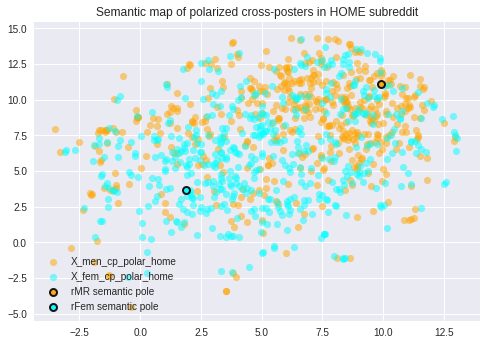

In [67]:
plt.scatter(X_tsne[:500, 0], X_tsne[:500, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[500:1000, 0], X_tsne[500:1000, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2, edgecolors="k")
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2, edgecolors="k")
plt.legend(["X_men_cp_polar_home",
            "X_fem_cp_polar_home",
            "rMR semantic pole",
            "rFem semantic pole"], loc=3)
plt.title("Semantic map of polarized cross-posters in HOME subreddit")
plt.show()

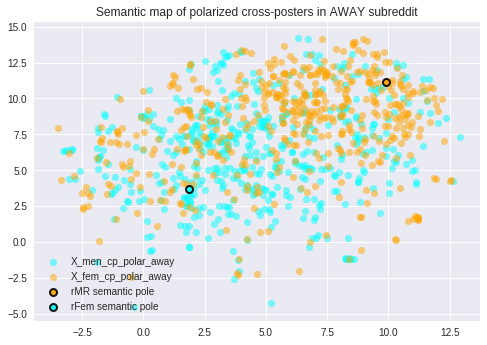

In [68]:
plt.scatter(X_tsne[1000:1500, 0], X_tsne[1000:1500, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[1500:2000, 0], X_tsne[1500:2000, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2, edgecolors="k")
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2, edgecolors="k")
plt.legend(["X_men_cp_polar_away",
            "X_fem_cp_polar_away",
            "rMR semantic pole",
            "rFem semantic pole"], loc=3)
plt.title("Semantic map of polarized cross-posters in AWAY subreddit")
plt.show()

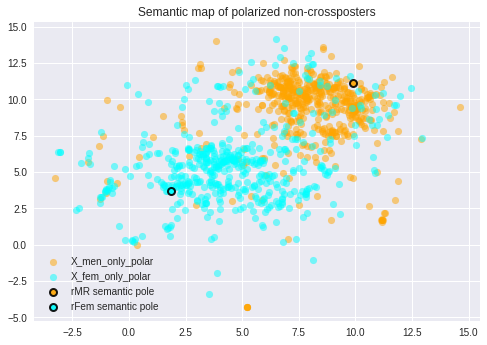

In [69]:
plt.scatter(X_tsne[2000:2500, 0], X_tsne[2000:2500, 1], c="orange", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[2500:3000, 0], X_tsne[2500:3000, 1], c="cyan", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[3000, 0], X_tsne[3000, 1], c="orange", alpha=0.9, linewidths=2, edgecolors="k")
plt.scatter(X_tsne[3001, 0], X_tsne[3001, 1], c="cyan", alpha=0.9, linewidths=2, edgecolors="k")
plt.legend(["X_men_only_polar",
            "X_fem_only_polar",
            "rMR semantic pole",
            "rFem semantic pole"], loc=3)
plt.title("Semantic map of polarized non-crossposters")
plt.show()

Intuitively, 

1. The author vectors from rMR are semantically separated from author vectors from rFem. 
2. The distribution of cross-poster author vectors (either in home or away subreddit) look more diffusive than the non-crossposters (`X_men_only_polar` and `X_fem_only_polar`).

Again, just like document vector of top-scoring posts, we'll compute the distance (cosine and Euclidean) of author vectors with respect to the semantic poles (`X_men_specific_word_mean` and `X_fem_specific_word_mean`).

In [70]:
cosine_men_cp_polar_home, euclidean_men_cp_polar_home = cos_and_eucl_dist(X_men_cp_polar_home, [X_men_specific_word_mean])
cosine_fem_cp_polar_away, euclidean_fem_cp_polar_away = cos_and_eucl_dist(X_fem_cp_polar_away, [X_men_specific_word_mean])
cosine_men_only_polar, euclidean_men_only_polar = cos_and_eucl_dist(X_men_only_polar, [X_men_specific_word_mean])

In [71]:
%matplotlib inline

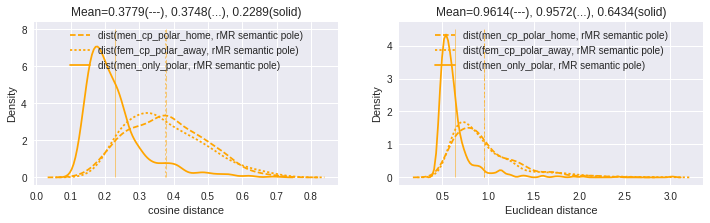

In [72]:
plot_dist([cosine_men_cp_polar_home, cosine_fem_cp_polar_away, cosine_men_only_polar],
          [euclidean_men_cp_polar_home, euclidean_fem_cp_polar_away, euclidean_men_only_polar],
          [8, 4.5],
          titles=["Mean=%.4f(---), %.4f(...), %.4f(solid)" %(cosine_men_cp_polar_home.mean(), cosine_fem_cp_polar_away.mean(), cosine_men_only_polar.mean()),
                  "Mean=%.4f(---), %.4f(...), %.4f(solid)" %(euclidean_men_cp_polar_home.mean(), euclidean_fem_cp_polar_away.mean(), euclidean_men_only_polar.mean())],
          colors=["orange", "orange", "orange"],
          linestyle=["dashed", "dotted", "-"],
          labels=["dist(men_cp_polar_home, rMR semantic pole)",
                  "dist(fem_cp_polar_away, rMR semantic pole)",
                  "dist(men_only_polar, rMR semantic pole)"])

In [73]:
cosine_fem_cp_polar_home, euclidean_fem_cp_polar_home = cos_and_eucl_dist(X_fem_cp_polar_home, [X_fem_specific_word_mean])
cosine_men_cp_polar_away, euclidean_men_cp_polar_away = cos_and_eucl_dist(X_men_cp_polar_away, [X_fem_specific_word_mean])
cosine_fem_only_polar, euclidean_fem_only_polar = cos_and_eucl_dist(X_fem_only_polar, [X_fem_specific_word_mean])

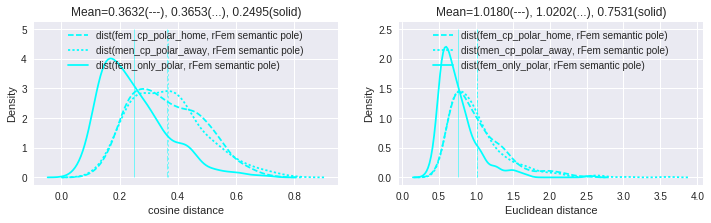

In [74]:
plot_dist([cosine_fem_cp_polar_home, cosine_men_cp_polar_away, cosine_fem_only_polar],
          [euclidean_fem_cp_polar_home, euclidean_men_cp_polar_away, euclidean_fem_only_polar],
          [5., 2.5],
          titles=["Mean=%.4f(---), %.4f(...), %.4f(solid)" % (cosine_fem_cp_polar_home.mean(), cosine_men_cp_polar_away.mean(), cosine_fem_only_polar.mean()),
                  "Mean=%.4f(---), %.4f(...), %.4f(solid)" % (euclidean_fem_cp_polar_home.mean(), euclidean_men_cp_polar_away.mean(), euclidean_fem_only_polar.mean())],
          colors=["cyan", "cyan", "cyan"],
          linestyle=["dashed", "dotted", "-"],
          labels=["dist(fem_cp_polar_home, rFem semantic pole)",
                  "dist(men_cp_polar_away, rFem semantic pole)",
                  "dist(fem_only_polar, rFem semantic pole)"])

In [75]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


Clearly, the author vectors of non-crossposters (solid lines) are much closer to the corresponding semantic poles than cross-posters. 

Note that we also made the comparison between the distances of cross-posters' author vector in *home* and *away* subreddit with respect to semantic poles. It appears that the difference between the two groups of distances is very negligible (e.g. dashed vs. dotted lines).

## 3.2 Semantic Characterization of Authors: Semantic Span

Note that author vector characterizes an author by semantically summarizing all his/her posts -- it's obtained by reducing many document vectors to their mean. 

Alternatively, authors can also be characterized by the semantic *span* -- the extent to which his/her posts are semantically apart from each other. For example, authors who covers many different topics would have larger semantic span than those who focuses on a single topic.

We can define semantic span as the average distance over an author's document vectors with respect to their mean. It's conceptually similar with the *distortion* or *inertia* when you evaluate a clustering algorithm. 

In [76]:
del men_counter, fem_counter, background_counter, df

In [77]:

def semantic_span(author, subreddits, cutoffs, total):
    """
        Computes the semantic span of `author`'s posts in `subreddits` (e.g. ["MensRights", "Feminism"]).
        
        `cutoffs` contains the mininum numbers of posts required separately for each subreddit
        `total` contains the total number of posts from `subreddits` combined
        
        Both conditions must be met, otherwise returns `np.array([np.nan, np.nan])`
    """
    vec = []
    supports = [0.] * len(subreddits) # count the number of posts in different subreddits separately
    
    for i, subreddit in enumerate(subreddits):
        post_by_author = db[subreddit].find({"author": author}, {"score": 1, "_id": 1})
        for post in post_by_author:
            if str(post["_id"]) in model.docvecs:
                vec.append(model.docvecs[str(post["_id"])])
                supports[i] += 1.
                
    vec = np.array(vec)
    a = np.array([supports, cutoffs])
    
    if (a[0, :] >= a[1, :]).all() and sum(supports) >= total:
        center = vec.mean(axis=0)

        return np.array(cos_and_eucl_dist(vec, [center])).mean(axis=1)
    else:
        return np.array([np.nan, np.nan])

We'll compute the *semantic spans* of eight groups of authors:
1. 500 top-scoring rMR-polarized cross-posters (`men_cp_polar`)
2. 500 top-scoring rFem-polarized cross-posters (`fem_cp_polar`)
3. 500 top-scoring rMR-only authors (`men_only_polar`)
4. 500 top-scoring rFem-only authors (`fem_only_polar`)
5. all cross-posters
6. all rMR-only authors
7. all rFem-only authors
8. **all authors**

Group 1-4 are the same as in the previous section (cell Num. 47). Note that unlike the previous section, the semantic spans for cross-posters (groups 1, 2, 5) are computed over all the posts from *both subreddits* **r/MensRights** and **r/Feminism**.

We'll use group 8 as a baseline to which the semantic spans of group 1-7 will be compared.

In [78]:
crossposter = list(authors[(authors["men_count"] > 0) & (authors["fem_count"] > 0)].index)
men_only = list(authors[(authors["men_count"] > 0) & (authors["fem_count"] == 0)].index)
fem_only = list(authors[(authors["men_count"] == 0) & (authors["fem_count"] > 0)].index)

subreddits = [["MensRights", "Feminism"],
              ["MensRights", "Feminism"],
              ["MensRights"],
              ["Feminism"],
              ["MensRights", "Feminism"],
              ["MensRights"],
              ["Feminism"],
              ["MensRights", "Feminism"]]

cutoffs = [[1, 1],
           [1, 1],
           [5],
           [5],
           [1, 1],
           [5],
           [5],
           [0, 0]]

total = [5] * 8

author_list = [men_cp_polar,
               fem_cp_polar,
               men_only_polar["author"],
               fem_only_polar["author"],
               crossposter,
               men_only,
               fem_only,
               authors.index]

labels = ["Semantic span(rMR-polarized500 crossposter):", 
          "Semantic span(rFem-polarized500 crossposter):",
          "Semantic span(rMR-only500 author):",
          "Semantic span(rFem-only500 author):",
          "Semantic span(all cross-posters):",
          "Semantic span(all rMR-only authors):",
          "Semantic span(all rFem-only authors)",
          "Semantic span(all authors)"]

In [79]:
data = []

for s, c, t, a in zip(subreddits, cutoffs, total, author_list):
    
    span = np.array(map(lambda x: semantic_span(x, s, c, t), a))
#    print span.shape
    span = span[~np.isnan(span[:, 0]), :]
#    print span.shape
#    print l, span.mean(axis=0)

    data.append(span)

In [80]:
%matplotlib inline

Semantic span(rMR-polarized500 crossposter):


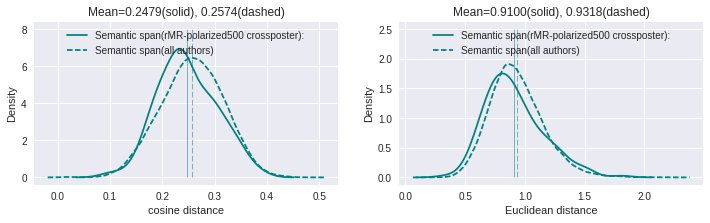

Semantic span(rFem-polarized500 crossposter):


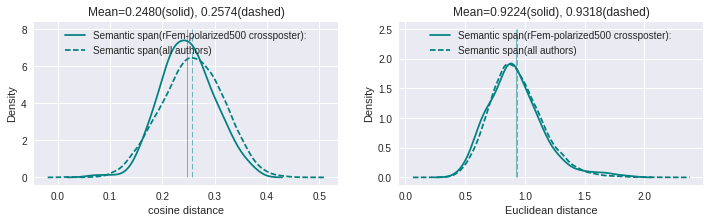

Semantic span(rMR-only500 author):


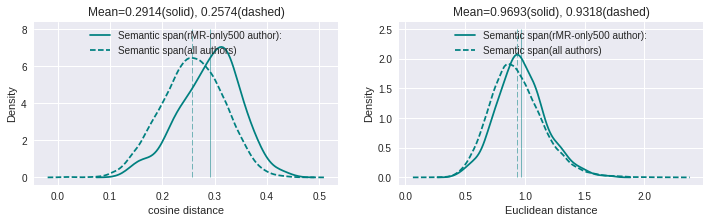

Semantic span(rFem-only500 author):


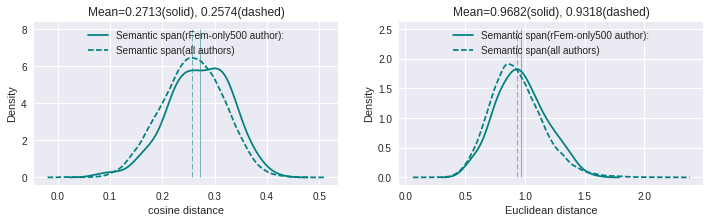

Semantic span(all cross-posters):


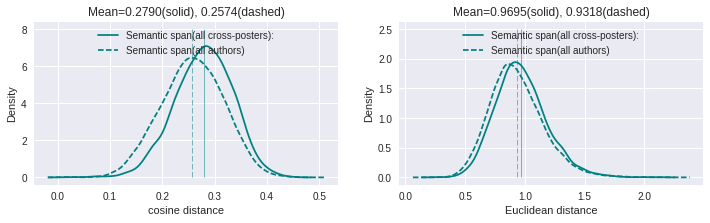

Semantic span(all rMR-only authors):


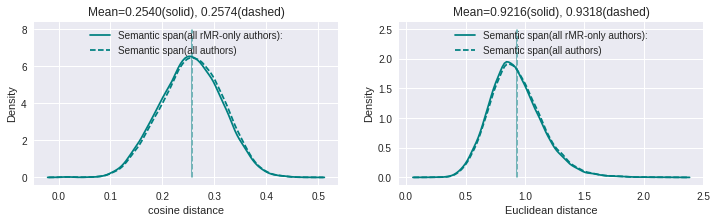

Semantic span(all rFem-only authors)


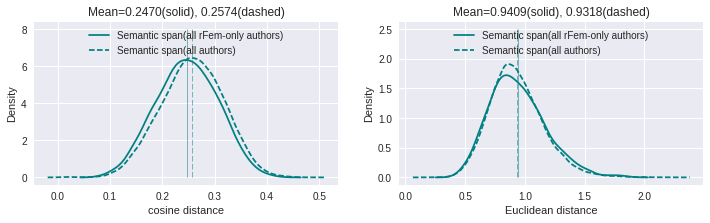

In [81]:
for i in range(7):

    print labels[i]
    plot_dist([data[i][:, 0], data[-1][:, 0]],
              [data[i][:, 1], data[-1][:, 1]],
              [8, 2.5],
              titles=["Mean=%.4f(solid), %.4f(dashed)" % (data[i][:, 0].mean(), data[-1][:, 0].mean()),
                  "Mean=%.4f(solid), %.4f(dashed)" % (data[i][:, 1].mean(), data[-1][:, 1].mean())],
              colors=["teal", "teal"],
              linestyle=["-", "dashed"],
              labels=[labels[i], labels[-1]])
    plt.show()

In [82]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


This table summarizes the averages of semantic spans of all author groups:

||Author groups|Avg. semantic span(cosine)|Avg. semantic span(Euclidean)|
|-|----|------|----|
|1|rMR-polarized500 crossposter|0.2479|0.9100|
|2|rFem-polarized500 crossposter|0.2480|0.9224|
|3|rMR-only500|0.2914|0.9693|
|4|rFem-only500|0.2713|0.9682|
|5|all cross-posters|0.2790|0.9695|
|6|all rMR-only authors|0.2540|0.9216|
|7|all rFem-only authors|0.2470|0.9409|
|8|**all authors**|0.2574|0.9318|

Note that, by definition, crossposters are those who posted in both subreddits rather than in only one. So chances are they would have covered more semantically different topics than those who only posted in only one subreddit, so it's easy to explain why group 5 has above-baseline semantic span.

However, if you look at the crossposters who received the highest scores (group 1, 2), they seem to have below-baseline semantic span, which means they seemed to have concentrated on semantically similar topics as opposed to the entire set of crossposters who covered semantically more different topics. 

## 4. The more interaction, the more similar semantically

Remember that each author comes with an author-vector, which is just the average of the document vectors from all his/her posts. So we can easily compute the semantic distance between any two authors. We may wonder what causes two authors to be semantically similar (or different). Among all the possible factors, we can easily measure how often two authors interact with each other, that is, the number of times their posts appeared in the same thread of discussion. And we'll check if this quantity correlates with the semantic similarity.

Note that posts appearing in the same thread are also from the same subreddit. So we have to compute the measure of strength of interaction separately for **r/MensRights** and **r/Feminism**.

Instead of running over all pairs of authors, we will focus on only three sets of authors that we have built previously, and compute the measure of strength of interaction, as well as their semantic distance over pairs of authors, when they are from the *same author set* OR from *different author set*.

Author sets:

||r/MensRights|r/Feminism|
|----|-----|----|
|1|`men_cp_polar_home` |`fem_cp_polar_home` |
|2|`fem_cp_polar_away` |`men_cp_polar_away` |
|3|`men_only_polar` |`fem_only_polar` |

Author interactions:

||author `a1`|author `a2`|intra- or inter- author sets|
|---|---|---|---|
|1|`men_cp_polar_home`|`men_cp_polar_home`|intra|
|2|`men_cp_polar_home`|`fem_cp_polar_away`|inter|
|3|`men_cp_polar_home`|`men_only_polar`|inter|
|4|`fem_cp_polar_away`|`fem_cp_polar_away`|intra|
|5|`fem_cp_polar_away`|`men_only_polar`|inter|
|6|`men_only_polar`|`men_only_polar`|intra|

||author `a1`|author `a2`|intra- or inter- author sets|
|---|---|---|---|
|1|`fem_cp_polar_home`|`fem_cp_polar_home`|intra|
|2|`fem_cp_polar_home`|`men_cp_polar_away`|inter|
|3|`fem_cp_polar_home`|`fem_only_polar`|inter|
|4|`men_cp_polar_away`|`men_cp_polar_away`|intra|
|5|`men_cp_polar_away`|`fem_only_polar`|inter|
|6|`fem_only_polar`|`fem_only_polar`|intra|

Retrieve posts from database and group them by the thread ID (`link_id`)

In [83]:
men_posts = pd.DataFrame(list(db["MensRights"].find({}, {"link_id": 1, "author": 1, "_id": 0})))
fem_posts = pd.DataFrame(list(db["Feminism"].find({}, {"link_id": 1, "author": 1, "_id": 0})))

men_by_author = men_posts.groupby("author").apply(lambda df: df["link_id"].unique())
fem_by_author = fem_posts.groupby("author").apply(lambda df: df["link_id"].unique())

In [84]:
men_by_author[-3:]

author
zzz8240               [t3_f4kz6]
zzzeumph    [t3_cqaqf, t3_cunl6]
zzzev                [t3_2plxcs]
dtype: object

In [85]:
fem_by_author[-3:]

author
zzastrow    [t3_2oi4dt]
zzpop10     [t3_31wtog]
zzurc       [t3_2y8h86]
dtype: object

In [86]:
def interaction_between(author_df1, author_df2, thread_df):
    """
    Given two authors `a1` from `author_df1` and `a2` from `author_df2`
    
    compute
    1. the number of threads in which `a1` and `a2` posted
    2. the cosine distance between vecotr of `a1` and `a2`
    """
    
    len1 = author_df1.shape[0]
    len2 = author_df2.shape[0]
    
    seen = dict()
    for i in range(len1):
        for j in range(len2):
            a1 = author_df1["author"].iat[i]
            a2 = author_df2["author"].iat[j]
            if a1 == a2:
                continue
            key = " ".join(sorted([a1, a2]))
            if key not in seen:
                count = len(set(thread_df[a1]) & set(thread_df[a2]))
                dist = distance.cosine(author_df1["vec"].iat[i], author_df2["vec"].iat[j])
                seen[key] = count, dist
                
    seen = pd.DataFrame(seen.values())
    seen.columns = ["count", "distance"]
    return seen          

def show_interaction_and_semdist(author_group, author_group_names, thread_df):
    dfs = []
    for i in range(3):
        for j in range(i, 3):
            df = interaction_between(author_group[i], author_group[j], thread_df)
            print author_group_names[i] + " vs. " + author_group_names[j]
            print df.mean()
            dfs.append(df)
    return dfs

In [87]:
men_author_group = [men_cp_polar_home, fem_cp_polar_away, men_only_polar]
men_author_group_names = ["men_cp_polar_home", "fem_cp_polar_away", "men_only_polar"]

fem_author_group = [fem_cp_polar_home, men_cp_polar_away, fem_only_polar]
fem_author_group_names = ["fem_cp_polar_home", "men_cp_polar_away", "fem_only_polar"]

Compute the following metrics for each pair of author sets:
* `count`: the average numbers of times two authors posts appearing in the same thread
* `distance`: the average cosine distance between two author vectors

In [88]:
men_dfs = show_interaction_and_semdist(men_author_group, men_author_group_names, men_by_author)

men_cp_polar_home vs. men_cp_polar_home
count       0.003447
distance    0.449260
dtype: float64
men_cp_polar_home vs. fem_cp_polar_away
count       0.001592
distance    0.445277
dtype: float64
men_cp_polar_home vs. men_only_polar
count       0.038768
distance    0.332845
dtype: float64
fem_cp_polar_away vs. fem_cp_polar_away
count       0.001130
distance    0.440118
dtype: float64
fem_cp_polar_away vs. men_only_polar
count       0.026292
distance    0.329335
dtype: float64
men_only_polar vs. men_only_polar
count       1.511142
distance    0.187225
dtype: float64


In [89]:
fem_dfs = show_interaction_and_semdist(fem_author_group, fem_author_group_names, fem_by_author)

fem_cp_polar_home vs. fem_cp_polar_home
count       0.001531
distance    0.479503
dtype: float64
fem_cp_polar_home vs. men_cp_polar_away
count       0.000988
distance    0.480313
dtype: float64
fem_cp_polar_home vs. fem_only_polar
count       0.007504
distance    0.398613
dtype: float64
men_cp_polar_away vs. men_cp_polar_away
count       0.001034
distance    0.480764
dtype: float64
men_cp_polar_away vs. fem_only_polar
count       0.005276
distance    0.400697
dtype: float64
fem_only_polar vs. fem_only_polar
count       0.047375
distance    0.303279
dtype: float64


As we can see, among all types of intra-author set relationship, `men_only_polar` and `fem_only_polar` (those who posted only in rMR/rFem and who received the highest scores) showed the strongest level of internal interaction and strongest semantic homogeneity, so they appeared to be very cohesive author communities in comparison to the crossposters.

Something I didn't expect is that the interaction between crossposters with different polarities (i.e. `men_cp_polar_home vs. fem_cp_polar_away` and `fem_cp_polar_home vs. men_cp_polar_away`) appeared to be very weak. Initially I thought that the polarized crossposters would account for most of the "cross-talk" (e.g. trolling) between **r/MensRights** and **r/Feminism**, but this argument is obvisouly not supported by the result.

In [90]:
men_dfs[0][-5:]

,count,distance
124745,0,0.633916
124746,0,0.442729
124747,0,0.193036
124748,0,0.533940
124749,0,0.667444


In [91]:
fem_dfs[0][-5:]

,count,distance
124745,0,0.268345
124746,0,0.533772
124747,0,0.427816
124748,0,0.382321
124749,0,0.554245


Lastly, let's return to the quetion we put forward in the beginning: if authors' semantic similarity is correlated with the level of interaction?

We'll concatenate the data from all pairs of author sets, and compute the groupwise average (**y-axis**) of semantic distance (grouped by count, that is, the numbers of times two authors' posts that appeared in the same thread, **x-axis**)

In [92]:
df = pd.concat(men_dfs, axis=0)
df = pd.concat([df["distance"].groupby(df["count"]).mean(),
               df["distance"].groupby(df["count"]).count()], axis=1)

df.columns = ["mean", "support"]

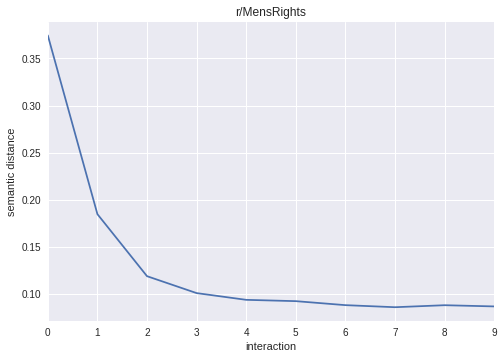

In [93]:
df[:10]["mean"].plot()
plt.title("r/MensRights")
plt.xlabel("interaction")
plt.ylabel("semantic distance")

In [94]:
df = pd.concat(fem_dfs, axis=0)
df = pd.concat([df["distance"].groupby(df["count"]).mean(),
               df["distance"].groupby(df["count"]).count()], axis=1)

df.columns = ["mean", "support"]

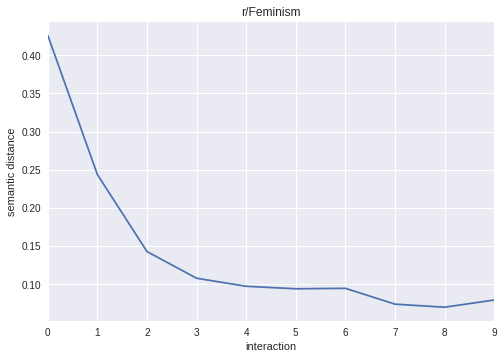

In [95]:
df[:10]["mean"].plot()
plt.title("r/Feminism")
plt.xlabel("interaction")
plt.ylabel("semantic distance")

Th answer is clear: the more two authors interact with each other, the more semantically similar they are. 

One thing that needs to be noticed is that this dataset has a large longitudinal span (i.e. from 2008 to 2016), but the analysis was based on the data aggregated across the entire range. So maybe it makes sense to take into account the temporal factors.